<a href="https://colab.research.google.com/github/Ohara124c41/Frontier_AI-I/blob/main/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Preface
このノートブックではニューラルネットワークを用いて，以下の基本的な問題に取り組みます．


*   CNNを使った画像分類

## 注意
このノートブックは，PyTorchの公式チュートリアルである [DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html#deep-learning-with-pytorch-a-60-minute-blitz) の [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) を日本語に翻訳し，必要に応じて必要事項を適宜補足したものです．

# ニューラルネットワーク





ニューラルネットワークはtorch.nnパッケージを使って構築することができます．
前回のノートブックでAutoGradについて解説しましたが，torch.nnはAutoGradを用いたモデルを定義します．</br>

nn.Moduleはレイヤーと出力を返すforward(input)メソッドを含みます．

例として，以下の数字画像を分類するネットワークを見てください．（図は[PyTorch公式チュートリアル](https://pytorch.org/tutorials/)より）


<img src="https://pytorch.org/tutorials/_images/mnist.png" border="0">



これは非常にシンプルなフィードフォワードネットワークの例となっています．具体的には，画像を入力とし，いくつかのレイヤーを次々と伝播した後に，最終的にその画像のクラスを表すone-hotベクトルを出力します．

典型的なニューラルネットワークの訓練手順は以下の6ステップから成ります．

1. 訓練の対象である重み（パラメータ）をもつニューラルネットワークを定義する

2. データセットから入力データを繰り返しネットワークに入力する

3. 入力をネットワークに伝播させる

4. 最終的な出力が正解データとどれくらい異なるかを表す誤差を計算する

5. 誤差をネットワークの各重みに逆伝播させる（バックプロパゲーション）

6. 5.で得られた勾配をもとにネットワークの各重みを更新する（最も単純な更新式の例としては， `weight = weight - learning_rate * gradient` など）


【**注意**】 以降でdrive中にファイルを読み込めるよう以下を実行しておいてください．

In [1]:
from google.colab import drive # driveを接続
drive.mount('/content/drive')

# drive中の課題ファイルのあるディレクトリに移動
%cd /content/drive/MyDrive/__FrontierAI-I/FAI20230606/

Mounted at /content/drive
/content/drive/MyDrive/__FrontierAI-I/FAI20230606


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

# ネットワークを定義する
では実際にニューラルネットワークを定義してみましょう．

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)   # 入力のチャネル数は1，出力のチャネル数は6，5x5の畳み込み層
        self.conv2 = nn.Conv2d(6, 16, 5)  # 入力のチャネル数は6，出力のチャネル数は16，5x5の畳み込み層

        # 線形層 y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))   # 大きさ(2,2)のMaxプーリング層
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)    # プーリングのWindowサイズの縦と横が同じ大きさなら，タプルではなく単一の値で指定できる
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]   # バッチの次元以外のすべての次元
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


ここで注目すべきは，backwardの計算（誤差逆伝播における重みの勾配の計算）は自分で実装する必要はないということです．forwardの計算のみを実装すれば，AutoGradによってbackwardの計算は裏側で自動的に組み込まれます．forwardの計算には，Tensorに対する演算を（基本的には）なんでも使うことができます．

学習対象となるモデルのパラメータは，net.parameters()で取得することができます．

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  #入力を3チャンネルに変更
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# net = Net().to(device)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # 訓練データを複数回(2周分)学習する

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # ローダからデータを取得する; データは [inputs, labels] の形で取得される．
        # イテレータを使用していないように見えますが for の内部で使用されています．
        inputs, labels = data

        # 勾配を0に初期化する(逆伝播に備える)．
        optimizer.zero_grad()

        # 順伝播 + 逆伝播 + 最適化(訓練)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 統計を表示する．
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2000 ミニバッチ毎に表示する．
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1の重みのSize

このネットワークに，大きさ32x32のランダム画像を入力してみます．


【**注意**】 MNISTデータセットの画像をこのネットワークに入力するためには，画像サイズを32x32にリサイズする必要があります．

In [ ]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

全ての重みの微分を0にリセットした後，ランダムな値でのlossの勾配をバックプロパゲーションします．

In [ ]:
net.zero_grad()
out.backward(torch.randn(1, 10))

【**注意**】
- `torch.nn`はバッチのみをサポートします．`torch.nn`パッケージでは一貫して，1つのサンプルではなく，サンプルのミニバッチを入力として扱うというルールがあります．
- 例えば，`nn.Conv2d`では，バッチサイズ x チャネル数 x 縦 x 横 の4次元のTensorを入力として受け付けます．
- もし1つのサンプルを用いたい場合は，`input.unsqueeze(0)`とすることで，バッチの次元を加えることで対処します．

先に進む前に，このあたりで今までの確認をしておきます．

- **`torch.Tensor`**<br/>
多次元配列のクラス．`backward()`などのAutoGradの操作をメソッドとしてもつ．また，各Tensorオブジェクトは，そのTensorに関する勾配として`grad`プロパティを保持します．

- **`nn.Module`**<br/>
ネットワークのモジュールのクラス．重みパラメータや各層の初期化，forward層とbackward層などをカプセル化しています．

- **`nn.Parameters`**<br/>
`nn.Module`に自動的に登録される重みパラメータのクラス．その実態はTensor．

# Loss Function
Loss Functionとは，(output, target)のペアを入力として，output（出力）とtarget（正解）がどれだけ異なるかを表す値（損失）を計算する関数のことです．

In [ ]:
# output = net(input)
# target = torch.randn(10)
# target = target.view(1, -1)  # targetのshapeをoutputのshapeと同じにしておく
# criterion = nn.MSELoss()

# loss = criterion(output, target)
# print(loss)

ここで，.grad_fn 属性を使用してlossから各層を逆方向に追ってみると，次のような計算グラフが構成されていることがわかります．

```
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> view -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss
```

`loss.backward()`を呼ぶと，lossに関してグラフ全体が微分され，グラフ中の`requires_grad=True`となっているTensorはその勾配を`.grad`プロパティに保持します．

# バックプロパゲーション
`loss.backward()`を呼ぶだけで，`loss`に関するバックプロパゲーションが行われます．今回のバックプロパゲーションを行う前に，以前のバックプロパゲーションで計算された勾配を0にリセットしておく必要があります．

以下では，`loss`に関するバックプロパゲーションを行い，`conv1`のバイアスパラメータの勾配の更新を確認しています．

In [ ]:
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([-0.0052, -0.0641, -0.0002, -0.0850,  0.0907,  0.0595])
conv1.bias.grad after backward
tensor([-0.0003, -0.0498,  0.0002, -0.0728,  0.0746,  0.0481])


# 重みの更新
実用的な更新式として最も単純なものは**確率的勾配降下法（Stochastic Gradient Descent, SGD）**でしょう．SGDは，以下のような更新式で重みを更新する手法です．

```
weight = weight - learning_rate * gradient
```


これは次のように簡単なPythonコードで実装できます：

In [ ]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

SGDの他にも，Nesterov-SGD, Adam, RMSPropなどの様々な重みの更新手法が存在し，PyTorchではそれらを`torch.optim`パッケージで管理しています．例えば，SGDを使いたい場合は単に
```
optim.SGD(net.paramters(), lr=0.01)
```
とすることで`Optimizer`クラスのインスタンスとしてSGDを生成し，これを使って次のように簡単に重みの更新を行うことができます：

In [ ]:
import torch.optim as optim

# optimizerを定義する
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 訓練のループの中で以下の処理を行う
optimizer.zero_grad()   # 各層の重みをゼロで初期化する
output = net(input)   # 入力からモデルを通して出力を計算
loss = criterion(output, target)    # 損失を計算
loss.backward()   # バックプロパゲーション
optimizer.step()    # 重みの更新を行う

### 注意
`optimizer.zero_grad()`を実行して手動で勾配をゼロにリセットする必要があることに注意してください．バックプロパゲーションの項で扱ったように，`grad`には`.backward`メソッドが実行されるたびに勾配が積算されるからです．

# 課題
定義した`MyAlexNet()`クラスを参考にAlexNetを再現してください．下図（右）にAlexNetの構造の詳細を示します．左は参考のために載せたLeNetの構造の詳細です．（図は[Dive into Deep Learning](http://d2l.ai/)より引用）<br>

<img src='http://d2l.ai/_images/alexnet.svg'>

【**注意**】
- 上図には書かれてありませんが、一番初めのConv層では`padding=2`で実装してください.
- strideが指定されていないところは`stride=1`で実装してください．
- 活性化関数には`nn.ReLU`を使用してください．
- denseでは`nn.Linear`を利用してください．
- 一番上の1000はクラス数なので解きたい課題に合わせて変更できるように`__init__`の引数`num_classes`として持っておくと便利です．


<details>
<summary>
課題：ヒント
</summary>
3回目のmaxpoolingのあと，Full connectionするためにはtensorのshapeを(batch数, 256*6*6)のベクトルに変えた後に(batch数, 4096)への線型層にかけます<br>
Net()を参考に変えてください

</details>

In [ ]:
from torchsummary import summary

In [ ]:
mynet = Net()
summary(mynet, (3, 6, 5))

In [6]:
#変換器の作成
#transforms.Composeによって複数の変換を組み合わせ、データを読み込む際に使用するデータ変換器を作成します．
#ここではPILImageをtorch.Tensorに変換したのち正規化を行う変換器を作成します．
transform = transforms.Compose(
    [transforms.ToTensor(),  # torch.Tensor へ変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 正規化する

#訓練データのダウンロードと変換
#扱うデータの集合であるデータセットを作成します．
#データは読み込まれる際に変換器によって変換され取り出されます．
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#訓練データのローダ(読み込み器)の作成
#データセットからデータを読み込むローダを作成します．
#ローダを挟むことで同時に幾つのデータを読み込むか、順番に読み込むかランダムに読み込むかなどデータの読み込み方を容易に設定できます．
#またnum_workersの指定によってデータ読み込みの並列化を容易に実現できます．
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

#テストデータのダウンロードと変換
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#テストデータのローダ(読み込み器)の作成
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


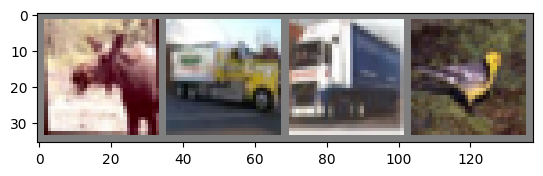

 deer truck truck  bird


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # [-1,1] を [0,1] へ戻す(正規化解除)
    npimg = img.numpy()  # torch.Tensor から numpy へ変換
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # チャンネルを最後に並び変える((C,X,Y) -> (X,Y,C))
    plt.show()  # 表示


# 訓練用画像を取得する
# pythonでは順番にデータを取得する際にイテレータと呼ばれるオブジェクトが介在します．
# ローダを使用してデータを読み込む際もイテレータを使用します．
dataiter = iter(trainloader)  # ローダを使って実際にデータを取得するためのイテレータを作成する．
# images, labels = dataiter.next()  # イテレータからデータを取得する．
images, labels = next(dataiter)  # イテレータからデータを取得する．

# 画像を表示する．
imshow(torchvision.utils.make_grid(images))
# ラベル(クラス)を表示する．
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
for epoch in range(2):  # 訓練データを複数回(2周分)学習する

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # ローダからデータを取得する; データは [inputs, labels] の形で取得される．
        # イテレータを使用していないように見えますが for の内部で使用されています．
        inputs, labels = data

        # 勾配を0に初期化する(逆伝播に備える)．
        optimizer.zero_grad()

        # 順伝播 + 逆伝播 + 最適化(訓練)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 統計を表示する．
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2000 ミニバッチ毎に表示する．
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.166
[1,  4000] loss: 1.837
[1,  6000] loss: 1.691
[1,  8000] loss: 1.607
[1, 10000] loss: 1.539
[1, 12000] loss: 1.492
[2,  2000] loss: 1.423
[2,  4000] loss: 1.418
[2,  6000] loss: 1.371
[2,  8000] loss: 1.344
[2, 10000] loss: 1.333
[2, 12000] loss: 1.313
Finished Training


余談ですが，自分が実装しているモデルの中間出力のshapeを知りたいときやパラメータの数を知りたいとき，`torchsummary`を使うと便利です．課題を解く際に使ってみてください

<details>
<summary>
解答
</summary>

    class MyAlexNet(nn.Module):
      def __init__(self, num_classes=1000):
        super(MyAlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

      def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 3, 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 3, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(F.relu(self.conv5(x)), 3, 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

      def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

</details>

In [9]:
# net.state_dict()によってネットワークの全パラメタ(重み)を格納した辞書を取得し，torch.saveで保存します．
# パラメタ(重み)でなくネットワークを丸ごと保存することも可能ですが、後々不便になることが多いです．
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

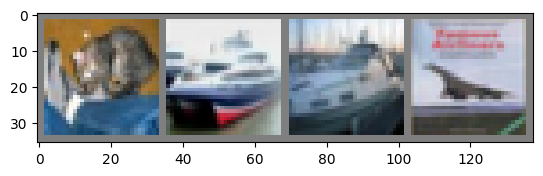

GroundTruth:    cat  ship  ship plane


In [10]:
# テストデータを取得
dataiter = iter(testloader)
images, labels = next(dataiter)

# 画像を表示
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
net = Net()  # ネットワークを再生成する（学習前の初期化されたネットワークになる）．
net.load_state_dict(torch.load(PATH))  # 保存しておいた学習後のパラメタ（重み）を読み込む．

<All keys matched successfully>

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 62 %
Accuracy of  bird : 29 %
Accuracy of   cat : 26 %
Accuracy of  deer : 28 %
Accuracy of   dog : 44 %
Accuracy of  frog : 83 %
Accuracy of horse : 63 %
Accuracy of  ship : 75 %
Accuracy of truck : 64 %


In [31]:
from torch.nn.modules.pooling import MaxPool2d
class MyAlexNet(nn.Module):
  def __init__(self, num_classes):
    super(MyAlexNet, self).__init__()
    self.num_classes = num_classes

    self.conv1 = nn.Conv2d(3,    96, kernel_size=7, stride = 1, padding=3)
    self.conv2 = nn.Conv2d(96,  384, kernel_size=5, stride = 1, padding=2)
    # self.conv3 = nn.Conv2d(256, 384, kernel_size=5, stride = 1, padding=1)
    self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride = 1, padding=1)
    # self.conv6 = nn.Conv2d(384, 512, kernel_size=3, stride = 1, padding=1)
    # self.conv7 = nn.Conv2d(512, 512, kernel_size=3, stride = 1, padding=1)
    # self.conv8 = nn.Conv2d(512, 384, kernel_size=3, stride = 1, padding=1)

    self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride = 1, padding=1)

    self.linear1 = nn.Linear(256 * 3 * 3, 4096)
    self.linear2 = nn.Linear(4096, 4096)
    self.linear3 = nn.Linear(4096, num_classes)

    # self.dropout1 = nn.Dropout(0.5) # drops half of the classes
    self.dropout2 = nn.Dropout(0.1)


  def forward(self, x):
    x = F.max_pool2d(F.leaky_relu(self.conv1(x)), 3, 2)
    x = self.dropout2(x)

    x = F.max_pool2d(F.leaky_relu(self.conv2(x)), 3, 2)

    # x = F.leaky_relu(self.conv3(x))
    x = F.leaky_relu(self.conv4(x))
    # x = self.dropout2(x)

    x = F.max_pool2d(F.leaky_relu(self.conv5(x)), 3, 2)

    x = torch.flatten(x, 1)
    x = F.leaky_relu(self.linear1(x))
    x = self.dropout2(x)

    x = F.leaky_relu(self.linear2(x))
    x = self.linear3(x)

    return x


device = 'cuda' if torch.cuda.is_available() else 'cpu'
mynet = MyAlexNet(10).to(device)

criterion = nn.CrossEntropyLoss()

## Baseline network
# optimizer = optim.SGD(mynet.parameters(), lr=0.001,  momentum=0.9) # 67%
# optimizer = optim.SGD(mynet.parameters(), lr=0.01,   momentum=0.9) # 32%
# optimizer = optim.SGD(mynet.parameters(), lr=0.005,  momentum=0.9) # 58%
# optimizer = optim.SGD(mynet.parameters(), lr=0.0005, momentum=0.9) # 58%

# optimizer = optim.SGD(mynet.parameters(), lr=0.1,    momentum=0.8) # 10% (momentum drop causes network to not learn)

params = mynet.parameters()
# optimizer = optim.Adam(params, lr=0.00001) # 53%
# optimizer = optim.Adam(params, lr=0.01)    # 10%
# optimizer = optim.Adam(params, lr=0.00005,  betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-5) # 68% w/ dropout 0.2
# optimizer = optim.Adam(params, lr=0.00005,  betas=(0.02, 0.9),  eps=1e-08, weight_decay=5e-5) # 59% w/ dropout 0.2
# optimizer = optim.Adam(params, lr=0.00005,  betas=(0.8, 0.999), eps=1e-08, weight_decay=5e-5) # 65% w/ dropout 0.2
# optimizer = optim.Adam(params, lr=0.00005,  betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-5) # 68% w/o dropout
# optimizer = optim.Adam(params, lr=0.00005,  betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-7) # 68% w/ dropout 0.5
# optimizer = optim.Adam(params, lr=0.00005,  betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-7) # 70% w/ dropout 0.10
# optimizer = optim.Adam(params, lr=0.0001,   betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-7) # 69% w/ dropout 0.10
# optimizer = optim.Adam(params, lr=0.000001, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-7) # 36% w/ dropout 0.10; loss plateau
# optimizer = optim.Adam(params, lr=0.00005, betas=(0.95, 0.999), eps=1e-08, weight_decay=3e-7) # 71% w/ 3x dropout 0.10, 4 hidden layers, loss: 0.850
optimizer = optim.Adam(params, lr=0.000075, betas=(0.95, 0.999), eps=1e-08, weight_decay=3e-7) # 72 % w/ 3x dropout 0.10, 4 hidden layers, loss: 0.816


In [ ]:
print(list(mynet.parameters()))
print(list(params))

In [ ]:
import torch

print(torch.__version__)

2.0.1+cu118


In [16]:
for epoch in range(2):  # 訓練データを複数回(2周分)学習する．

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # ローダからデータを読み込む; データは [inputs, labels] の形で取得される．
        inputs, labels = data

        # 勾配を0に初期化する（逆伝播に備える）．
        optimizer.zero_grad()

        # 順伝播 + 逆伝播 + 最適化
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mynet(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 統計を表示する．
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2000 ミニバッチ毎に表示する
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.894
[1,  4000] loss: 1.539
[1,  6000] loss: 1.385
[1,  8000] loss: 1.264
[1, 10000] loss: 1.174
[1, 12000] loss: 1.120
[2,  2000] loss: 0.974
[2,  4000] loss: 0.934
[2,  6000] loss: 0.904
[2,  8000] loss: 0.862
[2, 10000] loss: 0.840
[2, 12000] loss: 0.816
Finished Training


In [17]:
correct = 0
total = 0
with torch.no_grad():  #勾配計算をしない宣言（逆伝播用の計算グラフを作成しないことでメモリ節約、速度向上する）
    for data in testloader:
        images, labels = data
        images = images.to(device)
        with torch.no_grad():
          outputs = mynet(images)
        outputs = outputs.cpu()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 72 %
Accuracy of plane : 55 %
Accuracy of   car : 56 %
Accuracy of  bird : 39 %
Accuracy of   cat : 37 %
Accuracy of  deer : 39 %
Accuracy of   dog : 47 %
Accuracy of  frog : 68 %
Accuracy of horse : 56 %
Accuracy of  ship : 62 %
Accuracy of truck : 56 %


## Optimizerの変更、Dropout層の追加、アーキテクチャサイズの縮小、ハイパーパラメータの広範なチューニングを行った結果、最終的な精度値は**__72%__**でした。

* CIFARデータセットでは、収束性に優れていることから、Stochastic Gradient DescentよりもAdamオプティマイザが選択されました。

* β1値は0.9ではなく0.95を選択し、最適化を改善する可能性のある最近の勾配を強調するようにした。

* 学習率は、ハイパーパラメータのチューニングにより、この値が性能と収束を最適化することが示されたため、0.000075に設定された。

* 各隠れ層の間にはドロップアウト層が組み込まれ、学習中にニューロンを選択的に不活性化することでオーバーフィッティングを緩和した。

* 第2層のカーネルサイズは、空間情報の取得と計算効率のバランスを取るために、中程度のものを採用した。

* また、モデルの複雑さを軽減するため、層数を5層から4層に減らすことで、学習が促進され、オーバーフィッティングのリスクが軽減されました。